This notebook is a simple implementation of the two problems explored in https://pair.withgoogle.com/explorables/grokking/

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import seaborn as sns

## Modular addition

In [2]:
n = 24
m = 67

In [3]:
nums = np.arange(m)
X = []
i = 0
for a in nums:
    for b in nums[i:]:
        X.append((a, b))
    i += 1

In [4]:
random.shuffle(X)

In [5]:
y = torch.tensor([np.mod(a+b, m) for (a, b) in X]).type(torch.LongTensor)

In [6]:
n1 = int(len(X) * .8)
Xtr = X[:n1]
ytr = y[:n1]
Xte = X[n1:]
yte = y[n1:]

In [7]:
len(X)

2278

In [8]:
a = torch.zeros(len(Xtr), m)
b = torch.zeros(len(Xtr), m)
i = 0
for (numa, numb) in Xtr:
    a[i, numa] = 1
    b[i, numb] = 1
    i += 1

In [9]:
ate = torch.zeros(len(Xte), m)
bte = torch.zeros(len(Xte), m)
i = 0
for (numa, numb) in Xte:
    ate[i, numa] = 1
    bte[i, numb] = 1
    i += 1

In [10]:
W_in = torch.rand(n, m)
W_out = torch.rand(n, m)
parameters = [W_in, W_out]

for p in parameters:
    p.requires_grad = True

sum(param.nelement() for param in parameters)

3216

<Axes: >

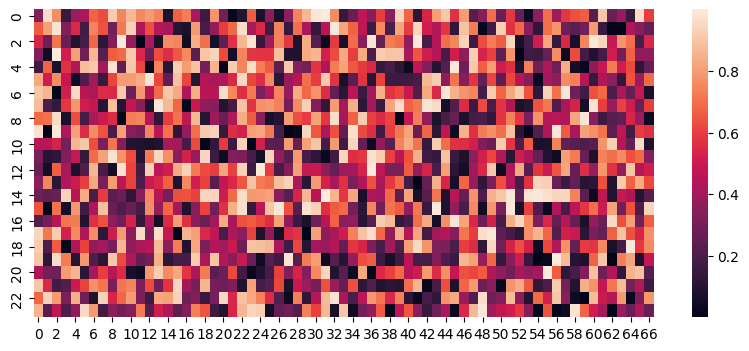

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(W_in.detach().numpy(), ax=ax)

<Axes: >

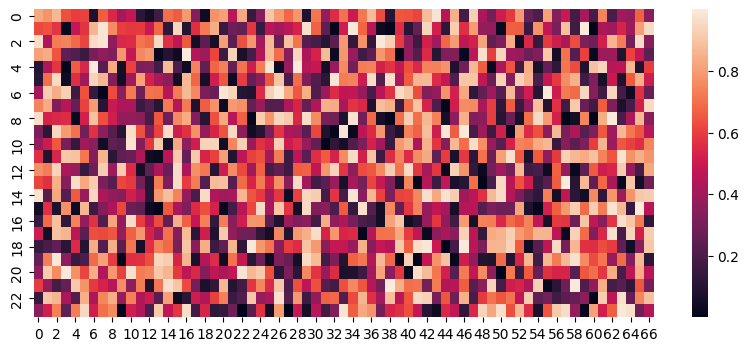

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(W_out.detach().numpy(), ax=ax)

In [13]:
# The model is trained with cross-entropy loss, AdamW and full batches.
# The section on regularization and training colab have additional details.

In [14]:
cross_entropy = torch.nn.CrossEntropyLoss()
opt = torch.optim.AdamW(parameters, lr=0.001, betas=(0.9, 0.999))

In [15]:
trainlosses = []
testlosses = []
for _ in range(50000):
    opt.zero_grad()

    out = torch.relu(a @ W_in.T + b @ W_in.T) @ W_out
    trainloss = cross_entropy(out, ytr)

    trainloss.backward()
    opt.step()

    trainlosses.append(trainloss.item())
    outte = torch.relu(ate @ W_in.T + bte @ W_in.T) @ W_out
    testloss = cross_entropy(outte, yte)
    testlosses.append(testloss.item())

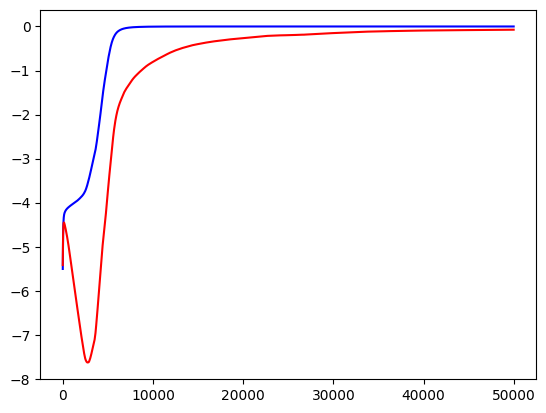

In [16]:
plt.plot(range(50000), [-loss for loss in trainlosses], color='b')
plt.plot(range(50000), [-loss for loss in testlosses], color='r')

In [17]:
a[42].tolist().index(1), b[42].tolist().index(1)

(29, 61)

In [19]:
(torch.relu(a[42] @ W_in.T + b[42] @ W_in.T) @ W_out).tolist().index(
    (torch.relu(a[42] @ W_in.T + b[42] @ W_in.T) @ W_out).max()
)

23

<Axes: >

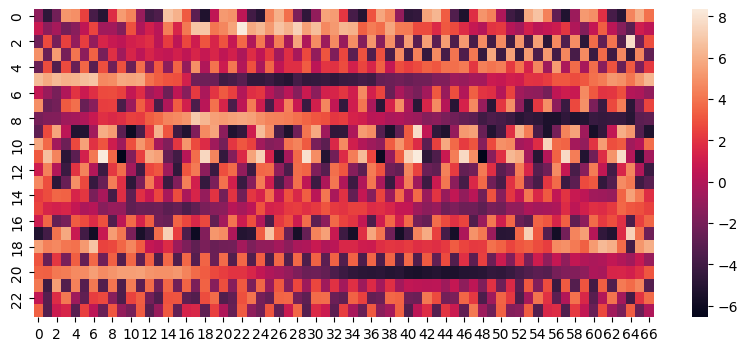

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(W_in.detach().numpy(), ax=ax)

<Axes: >

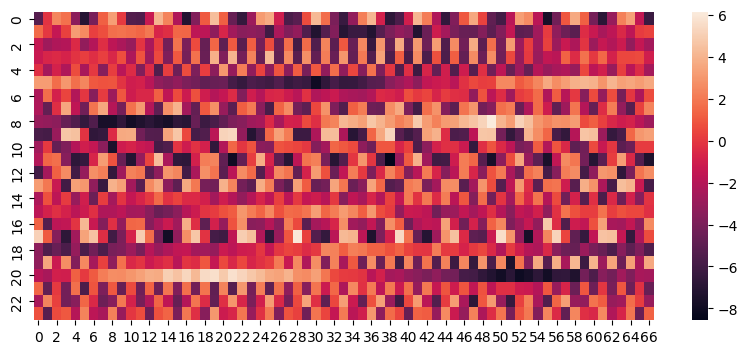

In [21]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(W_out.detach().numpy(), ax=ax)

Row are the dimensions of the 24-dimensional representation space. They exhibit a periodic pattern as the input number grows.

## Binary

In [22]:
a = torch.empty(1500, 30).uniform_(0, 1)
Xb = torch.bernoulli(a)

In [23]:
yb = []
for seq in Xb:
    if sum(seq[:3]) % 2:
        yb.append(1)
    else:
        yb.append(0)
yb = torch.tensor(yb)

In [24]:
n1b = int(1200)
Xbtr = Xb[:n1b]
ybtr = yb[:n1b]
Xbte = Xb[n1b:]
ybte = yb[n1b:]

In [25]:
W_inb = torch.rand(24, 30)
W_outb = torch.rand(24, 1)
parametersb = [W_inb, W_outb]

for p in parametersb:
    p.requires_grad = True

sum(param.nelement() for param in parametersb)

744

In [26]:
bcross_entropy = torch.nn.BCEWithLogitsLoss()
optb = torch.optim.AdamW(parametersb, lr=0.001, betas=(0.9, 0.999))

In [27]:
trainlossesb = []
testlossesb = []
for _ in range(50000):
    optb.zero_grad()

    outbtr = torch.relu(Xbtr @ W_inb.T) @ W_outb
    trainlossb = bcross_entropy(outbtr.squeeze(), ybtr.float())

    trainlossb.backward()
    optb.step()

    trainlossesb.append(trainlossb.item())
    outbte = torch.relu(Xbte @ W_inb.T) @ W_outb
    testlossb = bcross_entropy(outbte.squeeze(), ybte.float())
    testlossesb.append(testlossb.item())

In [28]:
# plt.plot(range(50000), [-loss for loss in trainlossesb], color='b')
# plt.plot(range(50000), [-loss for loss in testlossesb], color='r')

In [29]:
Xbtr[42]

tensor([0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.])

In [30]:
torch.sigmoid(torch.relu(Xbtr[42] @ W_inb.T) @ W_outb)

tensor([7.3880e-05], grad_fn=<SigmoidBackward0>)

In [31]:
ybtr[42]

tensor(0)

<Axes: >

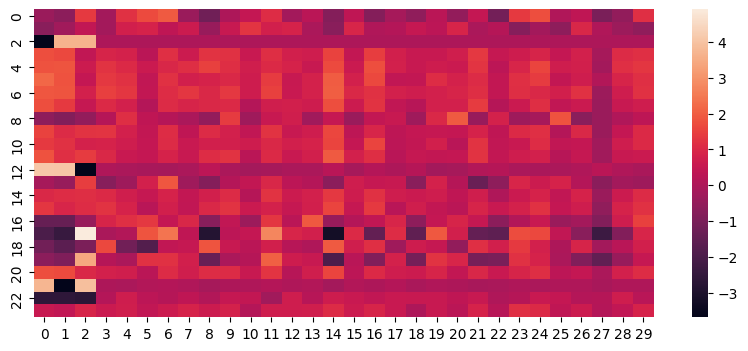

In [32]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(W_inb.detach().numpy(), ax=ax)

Instead of memorizing, model discovers that the relation is only dependent on the first three digits, and forms a theory based on that.